In [1]:
import patoolib # to extract the files
import pandas as pd # for data analysis and manipulation
import numpy as np # for scientific computing
import plotly.express as px # for visualization

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier # for random forest and feature selection
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.pipeline import Pipeline # for pipeline
from sklearn.preprocessing import * # for preprocessing
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score,  precision_score, recall_score # for evaluation
from sklearn.model_selection import RandomizedSearchCV # for hyperparameter tuning
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from datetime import datetime # date manipulation

In [2]:
# .rar extraction

#patoolib.extract_archive("raw/cancellation_prediction.rar", outdir="raw/")

# Reading dataset

In [3]:
df = pd.read_csv("raw/cancellation_prediction.csv")

# Data cleaning

### Checking NaN values

In [4]:
nan_df = pd.DataFrame()
values = []


for column in df.columns:
    nan_df[column] = [len(df[column].dropna())/len(df)]

nan_df = nan_df.T
    
fig = px.bar(nan_df, x=nan_df.index, y=0)
fig.show()

### Treating NaN values

In [5]:
df = df.drop(["id_person_booking"], axis=1)
df = df[df["country"].notna()]
df = df[df["num_children"].notna()]

In [6]:
nan_df = pd.DataFrame()
values = []


for column in df.columns:
    nan_df[column] = [len(df[column].dropna())/len(df)]

nan_df = nan_df.T
    
fig = px.bar(nan_df, x=nan_df.index, y=0)
fig.show()

# Mapping categorical variables

In [7]:
months_dict = dict((v,k) for k,v in zip(range(1, 13), sorted(df["month_arrival_date"].unique(), key=lambda m: datetime.strptime(m, "%B"))))
df['month_arrival_date'] = df['month_arrival_date'].map(months_dict)

df["breakfast"] = df["breakfast"]*1

rooms_dict = dict((v,k) for k,v in zip(range(len(df["reserved_room"].unique())), np.sort(df["reserved_room"].unique())))
df['reserved_room'] = df['reserved_room'].map(rooms_dict)

type_dict = dict((v,k) for k,v in zip(range(len(df["type"].unique())), np.sort(df["type"].unique())))
df['type'] = df['type'].map(type_dict)

deposit_dict = dict((v,k) for k,v in zip(range(len(df["deposit_policy"].unique())), np.sort(df["deposit_policy"].unique())))
df["deposit_policy"] = df["deposit_policy"].map(deposit_dict)

countries_dict = dict((v,k) for k,v in zip(range(len(df["country"].unique())), df["country"].unique()))
df["country"] = df["country"].map(countries_dict)

travel_agency_dict = dict((v,k) for k,v in zip(range(len(df["id_travel_agency_booking"].unique())), df["id_travel_agency_booking"].unique()))
df["id_travel_agency_booking"] = df["id_travel_agency_booking"].map(travel_agency_dict)

# Data description

In [8]:
# Tendency
mean = pd.DataFrame(df.mean()).round(2).T
median = pd.DataFrame(df.median()).round(2).T

# Dispersion
std = pd.DataFrame(df.std()).round(2).T
v_max = pd.DataFrame(df.max()).round(2).T
v_min = pd.DataFrame(df.min()).round(2).T

x = lambda x: x.max() - x.min()
v_range = pd.DataFrame(df.apply(x)).T

x = lambda x: x.skew().round(2)
skew = pd.DataFrame(df.apply(x)).T

x = lambda x: x.kurt().round(2)
kurt = pd.DataFrame(df.apply(x)).T

data_description = pd.concat([mean, median, std, v_max, v_min, v_range, skew, kurt]).T.reset_index()
data_description.columns = ["column", "mean", "median", "std", "max", "min", "range", "skew", "kurt"]
data_description

,column,mean,median,std,max,min,range,skew,kurt
0,type,0.67,1.0,0.47,1.0,0.0,1.0,-0.71,-1.50
1,cancellation,0.37,0.0,0.48,1.0,0.0,1.0,0.53,-1.72
2,days_between_booking_arrival,104.31,69.0,106.90,737.0,0.0,737.0,1.34,1.69
3,year_arrival_date,2016.16,2016.0,0.71,2017.0,2015.0,2.0,-0.23,-0.99
4,month_arrival_date,6.55,7.0,3.09,12.0,1.0,11.0,-0.03,-0.99
5,week_number_arrival_date,27.17,28.0,13.59,53.0,1.0,52.0,-0.01,-0.98
6,day_of_month_arrival_date,15.80,16.0,8.78,31.0,1.0,30.0,-0.00,-1.19
7,num_weekend_nights,0.93,1.0,1.00,16.0,0.0,16.0,1.30,5.66
8,num_workweek_nights,2.50,2.0,1.90,41.0,0.0,41.0,2.70,19.98
9,num_adults,1.86,2.0,0.58,55.0,0.0,55.0,18.46,1363.91


In [9]:
data_description[(data_description["kurt"] < -3) | (data_description["kurt"] > 3)]

,column,mean,median,std,max,min,range,skew,kurt
7,num_weekend_nights,0.93,1.0,1.00,16.0,0.0,16.0,1.30,5.66
8,num_workweek_nights,2.50,2.0,1.90,41.0,0.0,41.0,2.70,19.98
9,num_adults,1.86,2.0,0.58,55.0,0.0,55.0,18.46,1363.91
10,num_children,0.10,0.0,0.40,10.0,0.0,10.0,4.11,18.61
11,num_babies,0.01,0.0,0.10,10.0,0.0,10.0,24.70,1642.85
13,country,7.44,1.0,14.77,176.0,0.0,176.0,4.29,25.62
16,repeated_guest,0.03,0.0,0.18,1.0,0.0,1.0,5.32,26.27
17,num_previous_cancellations,0.09,0.0,0.85,26.0,0.0,26.0,24.43,671.96
18,num_previous_stays,0.13,0.0,1.48,72.0,0.0,72.0,24.04,794.61
20,changes_between_booking_arrival,0.22,0.0,0.65,21.0,0.0,21.0,6.01,79.47


In [10]:
df.corr()["cancellation"].sort_values(ascending=False)

cancellation                       1.000000
deposit_policy                     0.468497
days_between_booking_arrival       0.291994
market_segment                     0.236816
distribution_channel               0.168053
type                               0.133964
num_previous_cancellations         0.109922
num_adults                         0.058381
id_travel_agency_booking           0.049430
avg_price                          0.047858
num_workweek_nights                0.024110
year_arrival_date                  0.016412
breakfast                          0.014058
month_arrival_date                 0.010305
week_number_arrival_date           0.007465
num_children                       0.004751
num_weekend_nights                -0.002631
day_of_month_arrival_date         -0.006127
num_babies                        -0.032521
num_previous_stays                -0.055493
reserved_room                     -0.062230
repeated_guest                    -0.085179
country                         

# Features Manipulation

In [11]:
num_people = df["num_adults"] + df["num_children"] + df["num_babies"]
num_people = num_people.astype(int)
df["num_people"] = num_people
df = df.drop(["num_adults", "num_children", "num_babies"], axis=1)

In [12]:
df["required_car_parking_spaces"] = df["required_car_parking_spaces"].apply(lambda x: 1 if x > 0 else 0)

In [13]:
df["num_previous_cancellations"] = df["num_previous_cancellations"].apply(lambda x: 1 if x > 0 else 0)

In [14]:
df["num_previous_stays"] = df["num_previous_stays"].apply(lambda x: 1 if x > 0 else 0)

<AxesSubplot:>

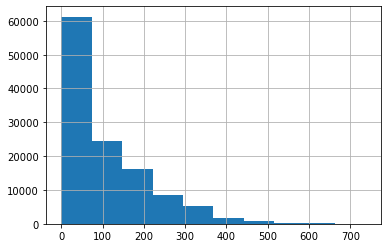

In [15]:
df["days_between_booking_arrival"].hist()

In [16]:
def new_values(x):
    if x >= 0 and x < 100:
        return 0
    if x >= 100 and x < 200:
        return 1
    if x >= 200 and x < 300:
        return 2
    else:
        return 3

In [17]:
values = []

for x in df["days_between_booking_arrival"]:
    values.append(new_values(x))

df["days_between_booking_arrival"] = values

<AxesSubplot:>

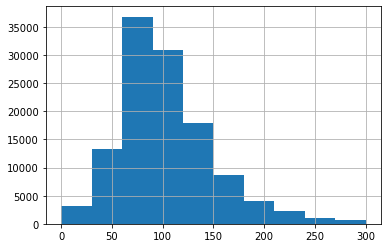

In [18]:
df["avg_price"].hist()

In [19]:
def new_values(x):
    if x >= 0 and x < 75:
        return 0
    if x >= 75 and x < 125:
        return 1
    if x >= 125 and x < 175:
        return 2
    else:
        return 3

In [20]:
values = []

for x in df["avg_price"].astype(int):
    values.append(new_values(x))

df["avg_price"] = values

In [21]:
# Tendency
mean = pd.DataFrame(df.mean()).round(2).T
median = pd.DataFrame(df.median()).round(2).T

# Dispersion
std = pd.DataFrame(df.std()).round(2).T
v_max = pd.DataFrame(df.max()).round(2).T
v_min = pd.DataFrame(df.min()).round(2).T

x = lambda x: x.max() - x.min()
v_range = pd.DataFrame(df.apply(x)).T

x = lambda x: x.skew().round(2)
skew = pd.DataFrame(df.apply(x)).T

x = lambda x: x.kurt().round(2)
kurt = pd.DataFrame(df.apply(x)).T

data_description = pd.concat([mean, median, std, v_max, v_min, v_range, skew, kurt]).T.reset_index()
data_description.columns = ["column", "mean", "median", "std", "max", "min", "range", "skew", "kurt"]
data_description

,column,mean,median,std,max,min,range,skew,kurt
0,type,0.67,1.0,0.47,1.0,0.0,1.0,-0.71,-1.50
1,cancellation,0.37,0.0,0.48,1.0,0.0,1.0,0.53,-1.72
2,days_between_booking_arrival,0.64,0.0,0.92,3.0,0.0,3.0,1.28,0.54
3,year_arrival_date,2016.16,2016.0,0.71,2017.0,2015.0,2.0,-0.23,-0.99
4,month_arrival_date,6.55,7.0,3.09,12.0,1.0,11.0,-0.03,-0.99
5,week_number_arrival_date,27.17,28.0,13.59,53.0,1.0,52.0,-0.01,-0.98
6,day_of_month_arrival_date,15.80,16.0,8.78,31.0,1.0,30.0,-0.00,-1.19
7,num_weekend_nights,0.93,1.0,1.00,16.0,0.0,16.0,1.30,5.66
8,num_workweek_nights,2.50,2.0,1.90,41.0,0.0,41.0,2.70,19.98
9,breakfast,0.77,1.0,0.42,1.0,0.0,1.0,-1.30,-0.31


In [22]:
df.corr()["cancellation"].sort_values(ascending=False)

cancellation                       1.000000
deposit_policy                     0.468497
num_previous_cancellations         0.270873
days_between_booking_arrival       0.259625
market_segment                     0.236816
distribution_channel               0.168053
type                               0.133964
id_travel_agency_booking           0.049430
num_people                         0.045031
avg_price                          0.035566
num_workweek_nights                0.024110
year_arrival_date                  0.016412
breakfast                          0.014058
month_arrival_date                 0.010305
week_number_arrival_date           0.007465
num_weekend_nights                -0.002631
day_of_month_arrival_date         -0.006127
reserved_room                     -0.062230
repeated_guest                    -0.085179
country                           -0.098421
num_previous_stays                -0.112270
customer_type                     -0.137180
changes_between_booking_arrival 

# Data Exploration

In [23]:
guest_city = df[df['cancellation'] == 0]['country'].value_counts().reset_index()
guest_city.columns = ['Country', 'n_clients']
inv_countries_dict = {v: k for k, v in countries_dict.items()}
guest_city["Country"] = guest_city["Country"].map(inv_countries_dict)
guest_city.sort_values(by="n_clients", ascending=False).iloc[0:10]

,Country,n_clients
0,PRT,21071
1,GBR,9676
2,FRA,8481
3,ESP,6391
4,DEU,6069
5,IRL,2543
6,ITA,2433
7,BEL,1868
8,NLD,1717
9,USA,1596


In [24]:
categories_values = list()
categories = sorted(df["days_between_booking_arrival"].unique())

for i in sorted(df["days_between_booking_arrival"].unique()):
    percentage = df.groupby("days_between_booking_arrival")["cancellation"].sum()[i] / len(df[df["days_between_booking_arrival"] == i])
    categories_values.append(percentage)

fig = px.bar(x=categories, y=categories_values, title="Cancellation Rate vs Days between booking arrival", color=categories)
fig.show()

In [25]:
categories_values = list()
categories = sorted(df["avg_price"].unique())

for i in sorted(df["avg_price"].unique()):
    percentage = df.groupby("avg_price")["cancellation"].sum()[i] / len(df[df["avg_price"] == i])
    categories_values.append(percentage)

fig = px.bar(x=categories, y=categories_values, title="Cancellation Rate vs Average price", color=categories)
fig.show()

In [26]:
rate_previous1 = df[df["num_people"] == 1]["cancellation"].sum() / len(df[df["num_people"] == 1])
rate_previous2 = df[df["num_people"] > 1]["cancellation"].sum() / len(df[df["num_people"] > 1])
categories = ["1", ">1"]

fig = px.bar(x=categories, y=[rate_previous1, rate_previous2], title="Cancellation Rate vs Number of people", color=categories)
fig.show()

In [27]:
categories_values = list()
categories = sorted(df["total_of_special_requests"].unique())

for i in sorted(df["total_of_special_requests"].unique()):
    percentage = df.groupby("total_of_special_requests")["cancellation"].sum()[i] / len(df[df["total_of_special_requests"] == i])
    categories_values.append(percentage)

fig = px.bar(x=categories, y=categories_values, title="Cancellation Rate vs Total Special Requests", color=categories)
fig.show()

In [28]:
categories_values = list()
categories = sorted(df["market_segment"].unique())

for i in sorted(df["market_segment"].unique()):
    percentage = df.groupby("market_segment")["cancellation"].sum()[i] / len(df[df["market_segment"] == i])
    categories_values.append(percentage)

fig = px.bar(x=categories, y=categories_values, title="Cancellation Rate vs Market Segment", color=categories)
fig.show()

In [29]:
categories_values = list()

for i in range(len(deposit_dict)):
    percentage = df.groupby("deposit_policy")["cancellation"].sum()[i] / len(df[df["deposit_policy"] == i])
    categories_values.append(percentage)

categories = ['No Deposit','Non Refund','Refundable']

fig = px.bar(x=categories, y=categories_values, title="Percentage of Cancellations by Deposit Policy", color=categories)
fig.show()

In [30]:
rate_previous1 = df[df["num_previous_cancellations"] == 0]["cancellation"].sum() / len(df[df["num_previous_cancellations"] == 0])
rate_previous2 = df[df["num_previous_cancellations"] > 0]["cancellation"].sum() / len(df[df["num_previous_cancellations"] > 0])
categories = ["0", ">0"]

fig = px.bar(x=categories, y=[rate_previous1, rate_previous2], title="Cancellation Rate vs Previous cancellation", color=categories)
fig.show()


# Feature Selection

### SelectKBest

In [31]:
X = df.drop("cancellation", axis=1) 
y = df["cancellation"]    

best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(X,y)

feature_scores_skb = pd.Series(fit.scores_, index=X.columns)
print(feature_scores_skb.nlargest(10))

fig = px.bar(x=feature_scores_skb.index, y=feature_scores_skb.values, color=feature_scores_skb.index)
fig.show()


country                            33809.429912
id_travel_agency_booking           27605.954635
deposit_policy                     23394.736273
days_between_booking_arrival       10571.189743
num_previous_cancellations          8250.775827
total_of_special_requests           7256.366750
market_segment                      5433.620610
changes_between_booking_arrival     4793.508529
required_car_parking_spaces         4318.127366
customer_type                       3327.556127
dtype: float64


### ExtraTreesClassifier

In [32]:
X = df.drop("cancellation", axis=1) 
y = df["cancellation"] 

model = ExtraTreesClassifier()
model.fit(X,y)

feat_importances_etc = pd.Series(model.feature_importances_, index=X.columns)
print(feat_importances_etc.nlargest(10))
fig = px.bar(x=feat_importances_etc.index, y=feat_importances_etc.values, color=feat_importances_etc.index)
fig.show()

deposit_policy                  0.130906
country                         0.113580
day_of_month_arrival_date       0.073335
total_of_special_requests       0.065203
week_number_arrival_date        0.058781
num_workweek_nights             0.056383
num_previous_cancellations      0.051738
id_travel_agency_booking        0.049105
days_between_booking_arrival    0.044735
market_segment                  0.040360
dtype: float64


In [33]:
list1_as_set = set(list(feat_importances_etc.nlargest(10).index))
intersection = list1_as_set.intersection(list(feature_scores_skb.nlargest(10).index))
intersection_as_list = list(intersection)

intersection_as_list

['id_travel_agency_booking',
 'deposit_policy',
 'days_between_booking_arrival',
 'market_segment',
 'num_previous_cancellations',
 'total_of_special_requests',
 'country']

# Model

### Data scaling

In [34]:
X = df.drop('cancellation',axis=1)
y = df["cancellation"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

### Entire dataset

In [35]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)
classifier_rf.fit(X_train, y_train)
classifier_rf.score(X_test, y_test)

0.7743650126156434

### Searching for Hyperparams

In [36]:
pipe = Pipeline([("rf", RandomForestClassifier())])

In [37]:

rf_hyperparams = {"rf__n_estimators": [100,150,200], # number of trees used in random forest, very high values could lead to overfitting
                 "rf__max_depth": [5, 10,15], # max depth of each tree, if the depth is too low, the accuracy is poor
                 "rf__criterion": ["gini", "entropy"], # to check whether impurity or information gain is the best way to split
                 "rf__min_samples_leaf": [3,5,10], # minimum samples beyond which a node cannot be split, higher values imply more generality
                 "rf__max_features": ["sqrt", "log2"], # to check what is the best way limit the number of features to each tree
                 "rf__bootstrap": ["True", "False"]} # to check whether bagging and aggregating results in a better model 

In [38]:
f1_wtd = make_scorer(f1_score, average="weighted")
pr_wtd = make_scorer(precision_score, average="weighted")
bal_acc_score = make_scorer(balanced_accuracy_score)
recall_wtd = make_scorer(recall_score, average = "weighted")

scoring_dict = {"bal_acc_score": bal_acc_score,
                "f1_wtd": f1_wtd,
                "pr_wtd": pr_wtd,
                "recall_wtd": recall_wtd}

In [39]:
rscv = RandomizedSearchCV(estimator=pipe,
                          param_distributions=rf_hyperparams,
                          n_iter = 10,
                          scoring = scoring_dict,
                          refit = "pr_wtd",
                          n_jobs = -1,
                          cv = 5,
                          random_state=42)

### Using best features from feature selection

In [40]:
X = df[intersection_as_list]
y = df["cancellation"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

result = rscv.fit(X_train, y_train)

In [41]:
print(result.best_params_)
print(result.best_score_)

{'rf__n_estimators': 100, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 15, 'rf__criterion': 'entropy', 'rf__bootstrap': 'False'}
0.827842191509788


In [42]:
pipe = result.best_estimator_
model = pipe.fit(X_train, y_train)

In [43]:
y_pred = model.predict(X_test)

In [44]:
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred): .4f}")
print(f"Precision score: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall score: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Balanced accuracy score:  0.7999
Precision score: 0.8277
Recall score: 0.8280
F1 score: 0.8243


### Using entire dataset

In [45]:
X = df.drop('cancellation',axis=1)
y = df["cancellation"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

result = rscv.fit(X_train, y_train)

In [46]:
print(result.best_params_)
print(result.best_score_)

{'rf__n_estimators': 100, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 15, 'rf__criterion': 'entropy', 'rf__bootstrap': 'False'}
0.8619621235149013


In [47]:
pipe = result.best_estimator_
model = pipe.fit(X_train, y_train)

In [48]:
y_pred = model.predict(X_test)

In [49]:
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred): .4f}")
print(f"Precision score: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall score: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Balanced accuracy score:  0.8340
Precision score: 0.8605
Recall score: 0.8594
F1 score: 0.8565


### Spliting by time

<AxesSubplot:xlabel='week_number_arrival_date'>

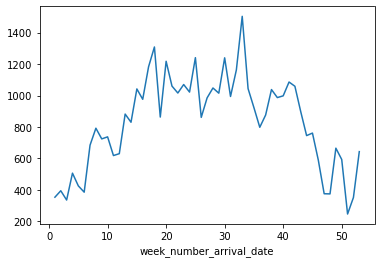

In [50]:
df.groupby("week_number_arrival_date")["cancellation"].sum().plot()

In [51]:
df[df["year_arrival_date"] == 2015].sort_values(by="month_arrival_date").iloc[0][["year_arrival_date", "month_arrival_date"]]

year_arrival_date     2015
month_arrival_date       7
Name: 0, dtype: int64

In [52]:
df[df["year_arrival_date"] == 2017].sort_values(by="month_arrival_date").iloc[-1][["year_arrival_date", "month_arrival_date"]]

year_arrival_date     2017
month_arrival_date       8
Name: 119389, dtype: int64

In [53]:
df[df["year_arrival_date"] == 2016].sort_values(by="month_arrival_date").iloc[0][["year_arrival_date", "month_arrival_date"]], df[df["year_arrival_date"] == 2016].sort_values(by="month_arrival_date").iloc[-1][["year_arrival_date", "month_arrival_date"]]

(year_arrival_date     2016
 month_arrival_date       1
 Name: 3738, dtype: int64,
 year_arrival_date     2016
 month_arrival_date      12
 Name: 104219, dtype: int64)

In [54]:
X_train = df[(df["year_arrival_date"] == 2015) | (df["year_arrival_date"] == 2016)].drop("cancellation", axis=1)
y_train = df[(df["year_arrival_date"] == 2015) | (df["year_arrival_date"] == 2016)]["cancellation"]

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

result = rscv.fit(X_train, y_train)

In [55]:
print(result.best_params_)
print(result.best_score_)

{'rf__n_estimators': 100, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 5, 'rf__criterion': 'gini', 'rf__bootstrap': 'False'}
0.7617773878944146


In [56]:
pipe = result.best_estimator_
model = pipe.fit(X_train, y_train)

In [57]:
X_test = df[(df["year_arrival_date"] == 2017)].drop("cancellation", axis=1)
y_test = df[(df["year_arrival_date"] == 2017)]["cancellation"]
y_pred = model.predict(X_test)

In [58]:
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred): .4f}")
print(f"Precision score: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall score: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Balanced accuracy score:  0.5000
Precision score: 0.3752
Recall score: 0.6125
F1 score: 0.4653


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

